# COVID 19 Epitope Prediction

## Data Exploration

### Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier

### Reading in the data

In [2]:
INPUT_DIR = 'https://raw.githubusercontent.com/efejiroe/covid_epitope_prediction/master/data/'
bcell = pd.read_csv(f'{INPUT_DIR}/input_bcell.csv')
sars = pd.read_csv(f'{INPUT_DIR}/input_sars.csv')

Quick look at the data to varified it's loaded. Both data sets have identical headers so merging is straighforward.

In [3]:
## sars training set part I
sars.head(3)

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
0,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,1,17,MFIFLLFLTLTSGSDLD,0.887,0.040,1.056,-2.159,5.569763,0.116335,-0.061116,33.205116,0
1,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,1,15,MFIFLLFLTLTSGSD,0.869,0.047,1.056,-2.500,5.569763,0.116335,-0.061116,33.205116,0
2,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,2,10,FIFLLFLTL,0.621,0.042,1.148,-7.467,5.569763,0.116335,-0.061116,33.205116,0


In [4]:
## bcell training set part II
bcell.head(3)

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
0,A2T3T0,MDVLYSLSKTLKDARDKIVEGTLYSNVSDLIQQFNQMIITMNGNEF...,161,165,SASFT,1.016,0.703,1.018,2.22,5.810364,0.103275,-0.143829,40.273300,1
1,F0V2I4,MTIHKVAINGFGRIGRLLFRNLLSSQGVQVVAVNDVVDIKVLTHLL...,251,255,LCLKI,0.770,0.179,1.199,-3.86,6.210876,0.065476,-0.036905,24.998512,1
2,O75508,MVATCLQVVGFVTSFVGWIGVIVTTSTNDWVVTCGYTIPTCRKLDE...,145,149,AHRET,0.852,3.427,0.960,4.28,8.223938,0.091787,0.879227,27.863333,1


In [5]:
## bsars consolidated training set
bsars = pd.concat([bcell, sars], axis=0, ignore_index=True)
bsars.head(3)

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
0,A2T3T0,MDVLYSLSKTLKDARDKIVEGTLYSNVSDLIQQFNQMIITMNGNEF...,161,165,SASFT,1.016,0.703,1.018,2.22,5.810364,0.103275,-0.143829,40.273300,1
1,F0V2I4,MTIHKVAINGFGRIGRLLFRNLLSSQGVQVVAVNDVVDIKVLTHLL...,251,255,LCLKI,0.770,0.179,1.199,-3.86,6.210876,0.065476,-0.036905,24.998512,1
2,O75508,MVATCLQVVGFVTSFVGWIGVIVTTSTNDWVVTCGYTIPTCRKLDE...,145,149,AHRET,0.852,3.427,0.960,4.28,8.223938,0.091787,0.879227,27.863333,1


### Data Assessment

No missing values or duplicate peptides were shown to exist in both training and test sets and the data types are described below.

In [6]:
## Checking columns for data type and null values
bsars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14907 entries, 0 to 14906
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   parent_protein_id    14907 non-null  object 
 1   protein_seq          14907 non-null  object 
 2   start_position       14907 non-null  int64  
 3   end_position         14907 non-null  int64  
 4   peptide_seq          14907 non-null  object 
 5   chou_fasman          14907 non-null  float64
 6   emini                14907 non-null  float64
 7   kolaskar_tongaonkar  14907 non-null  float64
 8   parker               14907 non-null  float64
 9   isoelectric_point    14907 non-null  float64
 10  aromaticity          14907 non-null  float64
 11  hydrophobicity       14907 non-null  float64
 12  stability            14907 non-null  float64
 13  target               14907 non-null  int64  
dtypes: float64(8), int64(3), object(3)
memory usage: 1.6+ MB


In [7]:
# Checking for duplicates
bsars_dups = bsars.pivot_table(index=['peptide_seq'], aggfunc='size')
print (bsars_dups)

peptide_seq
AAAAAAAT        1
AAAAAAATAS      1
AAAAAPAK        1
AAAAATASIA      1
AAAAVDTGSGGG    1
               ..
YYQKWMEE        1
YYQSAGRNSWNC    1
YYREMFAHH       1
YYRMMQTV        1
YYVPLGTQYT      1
Length: 14841, dtype: int64


### Feature Distribution and Importance

The binary target distribution of the training set is roughly 1:3. Basic statistics of features are shown below. Both correlation matrix, target plot seperations, and a classifier were used to assess feature importance. Aromaticity shown the highest feature importance score, an feature that showed little correlation to the target.

In [8]:
## Descriptive statistics 
bsars.describe()

,start_position,end_position,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
count,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000
mean,308.845173,319.519420,0.994906,1.082811,1.021808,1.750098,7.015227,0.077143,-0.394063,43.337674,0.271148
std,358.433563,358.647859,0.123656,1.826098,0.053430,1.954424,1.875713,0.026388,0.392808,16.501627,0.444567
min,1.000000,6.000000,0.534000,0.000000,0.838000,-9.029000,3.686096,0.000000,-1.971171,5.448936,0.000000
25%,86.000000,96.000000,0.913000,0.244000,0.987000,0.600000,5.569763,0.062500,-0.600131,31.725753,0.000000
50%,197.000000,208.000000,0.991000,0.551000,1.021000,1.775000,6.447815,0.075949,-0.318259,41.948275,0.000000
75%,400.000000,411.000000,1.073000,1.208500,1.055000,2.960000,8.676575,0.093458,-0.189591,49.101172,1.000000
max,3079.000000,3086.000000,1.546000,40.605000,1.255000,9.120000,12.232727,0.182254,1.267089,137.046667,1.000000


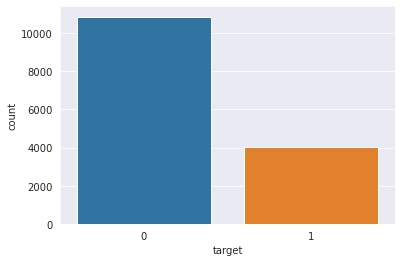

In [9]:
## Target variable countplot
sns.set_style('darkgrid')
sns.countplot(bsars['target'])

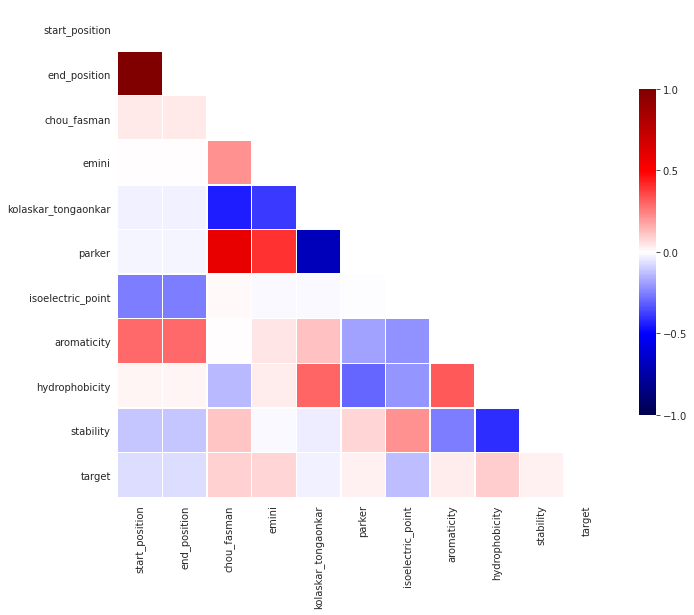

In [10]:
## Correlation Matrix
corr_matrix = bsars[[
    'parent_protein_id',
    'protein_seq',
    'start_position',
    'end_position', 
    'peptide_seq',
    'chou_fasman', 
    'emini',
    'kolaskar_tongaonkar',
    'parker', 
    'isoelectric_point',
    'aromaticity',
    'hydrophobicity',
    'stability', 
    'target'
]].corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

## heatmap properties
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(11, 15)) 
heatmap = sns.heatmap(
    corr_matrix, 
    mask = mask,
    square = True,
    linewidths = .5,
    cmap = 'seismic',
    cbar_kws = {'shrink': .4, 'ticks' : [-1, -.5, 0, 0.5, 1]},
    vmin = -1, 
    vmax = 1,
    annot = False,
    annot_kws = {'size': 12})

## labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

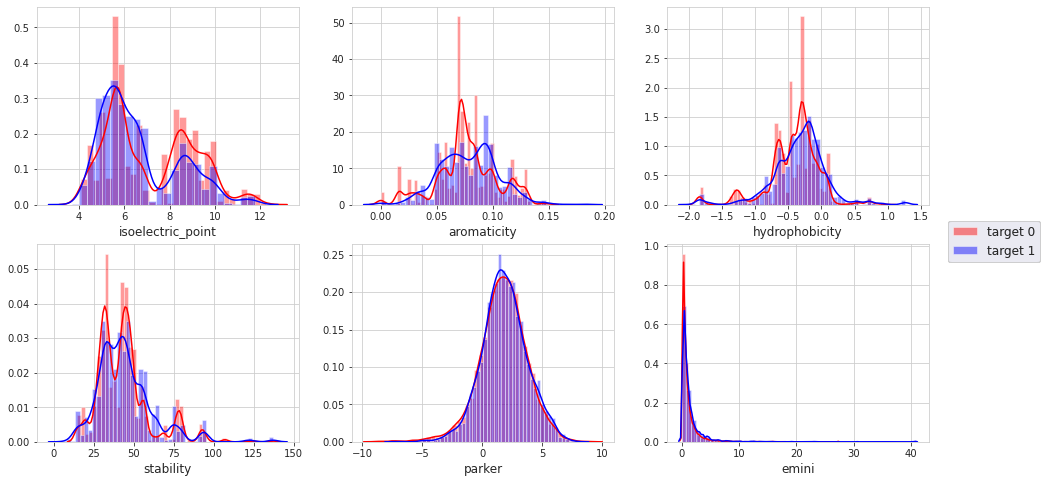

In [11]:
## Target variable plot seperations
idx_train = bsars['target'].astype("bool").values
fig, axes = plt.subplots(2, 3,figsize=(16,8))
sns.set_style('darkgrid')
axes = [x for a in axes for x in a]
for i,name in enumerate(["isoelectric_point", "aromaticity", "hydrophobicity", "stability", "parker", "emini"]):
    value = bsars[name]
    sns.distplot(value[~idx_train],ax = axes[i], color='red')
    sns.distplot(value[idx_train],ax = axes[i], color = 'blue')
    axes[i].set_xlabel(name,fontsize=12)
    fig.legend(labels = ["target 0","target 1"],loc="right",fontsize=12)

In [12]:
## Scoring Features
X = bsars.drop(['target', 'parent_protein_id', 'protein_seq', 'peptide_seq'], axis = 1)
y = bsars['target']
forest_classifier = ExtraTreesClassifier(n_estimators=250, random_state=420)
forest_classifier.fit(X,y)

ExtraTreesClassifier(n_estimators=250, random_state=420)

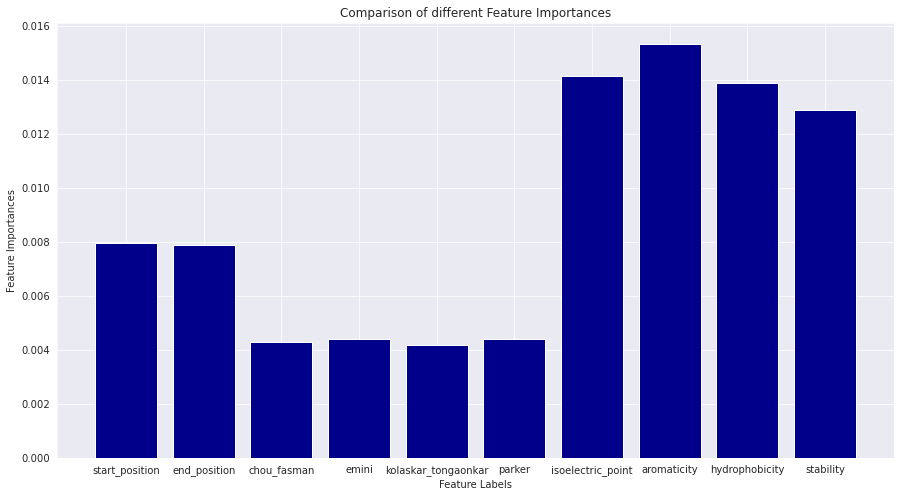

In [13]:
imp_features = forest_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_classifier.estimators_], axis = 0)
 
plt.figure(figsize = (15,8))
plt.bar(X.columns, std, color = 'darkblue') 
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances') 
plt.title('Comparison of different Feature Importances') 
plt.show()